In [8]:
import gzip
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt

读取解压的文件

即将四个.gz文件解压，这种读取方式有很多种，如下：

- 使用np.fromfile读取
- 使用idx2numpy模块读取
- 使用array读取

In [9]:
data_path = "../data/" 
file_name = {"train": ("train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz"), 
             "test": ("t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz")}


def get_data(data_type): 
    image_file = data_path + file_name[data_type][0] 
    label_file = data_path + file_name[data_type][1] 

    with gzip.open(label_file, "rb") as f: 
        f.read(8) 
        labels = np.frombuffer(f.read(), dtype=np.uint8) 

    with gzip.open(image_file, "rb") as f: 
        f.read(16) 
        content = np.frombuffer(f.read(), dtype=np.uint8) 
        images = content.reshape(-1, 28, 28)

    return images, labels

x_train, y_train = get_data("train") 
x_test, y_test = get_data("test")

# plt.imshow(x_test[2])

However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers

In [28]:
from sklearn.manifold import LocallyLinearEmbedding
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

class MNIST(Dataset): 
    def __init__(self, data_type, transform=None, inbalance=False):
        super().__init__() 
        self.data, self.labels = get_data(data_type)  
        if inbalance == True : # 构造类别不平衡数据
            label_idx = {}; label_num = {}  # 每个数字对应的数据下标；构造的inbalance数据每个数字样本个数 
            for i in range(0, 10): 
                label_idx[i] = [j for j in range(0, len(self.labels)) if self.labels[j] == i] 
                # print(len(label_idx[i]))
                label_num[i] = int(len(label_idx[i]) / (i % 3 * 2 + 1))
                label_idx[i] = label_idx[i][:label_num[i]] # 每个数字样本集取前num个 
                # print(len(label_idx[i]), label_num[i])


            new_idx = []
            for i in range(0, 10): 
                new_idx += label_idx[i]
            # print(new_idx, len(new_idx))
            # print(np.array(self.data).shape)
            # print(np.array(self.labels).shape)
            self.data = np.array(self.data)[new_idx]
            self.labels = np.array(self.labels)[new_idx]
            
            # print(np.array(self.data).shape)
            # print(np.array(self.labels).shape)
            # 重新索引
        self.data = torch.tensor(self.data, dtype=torch.float)
        
        self.labels = torch.tensor(self.labels, dtype=torch.long) # ? float & float64
        self.transform = transform


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img, label = self.data[index], self.labels[index]
        if self.transform : 
            img = self.transform(img)
        img = img.unsqueeze(0)
        # print(label)

        return img, label 

In [31]:
ds = MNIST("train", transform=lambda x: x / 255, inbalance=True)
print(len(ds))

33648


In [41]:
list(range(0,10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

AttributeError: 'Rectangle' object has no property 'yticks'

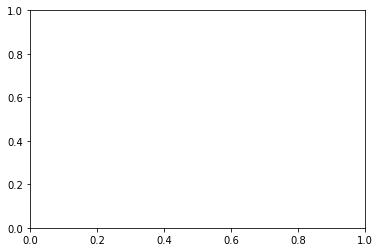

In [44]:
from matplotlib.pyplot import xticks


label_idx = {}; label_num = {}  # 每个数字对应的数据下标；构造的inbalance数据每个数字样本个数 
for i in range(0, 10): 
    label_idx[i] = [j for j in range(0, len(ds.labels)) if ds.labels[j] == i] 


<BarContainer object of 10 artists>

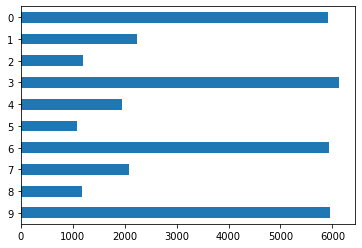

In [68]:
# plt.figure(figsize=(10, 12))
# plt.bar(list(range(0,10)),[len(label_idx[i]) for i in range(0,10)])
# plt.xticks(list(range(0,10)))
plt.yticks(list(range(0, 10)))
plt.ylim(9.5, -0.5)
plt.barh(list(range(0,10)),[len(label_idx[i]) for i in range(0,10)],height=0.5,left=list(range(0,10)))

In [1]:
def show_dataset(dataset):
    col = 3; row = 4
    fig = plt.figure(figsize=(9, 12))

    j = 0
    for i in range(col * row):
        idx = j
        j += 1
        
        x = dataset[idx][0];  y = dataset[idx][1].item()
        fig.add_subplot(row, col, i + 1)
        plt.axis("off")
        plt.imshow(x.squeeze())
        plt.title(y)